In [33]:
%matplotlib inline

import numpy as np
from numpy.fft import fftshift, fftn
import matplotlib.pyplot as plt

In [34]:
# qxx = np.linspace(-0.5, 0.5, 201)
qzz = np.linspace(-0.5, 0.5, 201)
pitch = 100
qxx = 2 * np.pi / pitch * np.ones_like(qzz)
qx, qz = np.meshgrid(qxx, qzz)

In [35]:
def trapezoid_form_factor(qy, qz, y1, y2, langle, rangle, h):
    m1 = np.tan(langle)
    m2 = np.tan(np.pi - rangle)
    t1 = qy + m1 * qz
    t2 = qy + m2 * qz
    with np.errstate(divide='ignore'):
        t3 = m1 * np.exp(-1j * qy * y1) * (1 - np.exp(-1j * h / m1 * t1)) / t1
        t4 = m2 * np.exp(-1j * qy * y2) * (1 - np.exp(-1j * h / m2 * t2)) / t2
        ff = (t4 - t3) / (1E-10 + qy)
    return ff

def stacked_trapezoids(qy, qz, y1, y2, height, langle, offset, rangle=None, profile=None):

    if not isinstance(langle, np.ndarray):
        raise TypeError('anlges should be array')
    if rangle is not None:
        if not langle.size == rangle.size:
            raise ValueError('both angle array are not of same size')
    else:
        rangle = langle
    
    if offset is None:
        offset=[0]*len(langle)
    
    ff = np.zeros(qz.shape, dtype=complex)
    xss, yss = np.zeros((4*langle.shape[0])), np.zeros((4*langle.shape[0]))
    # loop over all the angles
    for i in range(langle.size):
        if y1[i]!=0:
            y1_temp = y1[i]
            y2_temp = y2[i]
        
        xss[2*i], xss[yss.size-2*i-1] = y1_temp+offset[i], y2_temp+offset[i]
        yss[2*i], yss[xss.size-2*i-1] = (i)*height, (i)*height
        
        shift = height * i
        left, right = langle[i], rangle[i]
        ff += trapezoid_form_factor(qy, qz, y1_temp+offset[i], y2_temp+offset[i], left, right, height) * np.exp(-1j * shift * qz)
        m1 = np.tan(left)
        m2 = np.tan(np.pi - right)
        
        y1_temp += height / m1
        y2_temp += height / m2
        
        xss[2*i+1], xss[yss.size-(2*i+1)-1] = y1_temp+offset[i], y2_temp+offset[i]
        yss[2*i+1], yss[xss.size-(2*i+1)-1] = (i+1)*height, (i+1)*height
        
    
    
    if profile:
        return ff, xss, yss
    else:
        return ff

In [36]:
nb_trap_per_top=3
nb_trap_per_bot=3
w01=40
w02=20
height = 10
langle = np.asarray([90, 90, 90, 90, 90, 90])
ovl = 10

def create_castle_shape(nb_trap_per_top, nb_trap_per_bot, left_coord, right_coord, height, langle, ovl):
    list_w0g = [-0.5*left_coord] + [0]*(nb_trap_per_bot-1) + [-0.5*right_coord] + [0]*(nb_trap_per_top-1)
    list_w0r = [0.5*left_coord] + [0]*(nb_trap_per_bot-1) + [0.5*right_coord] + [0]*(nb_trap_per_top-1)
    list_ovl = [0]*nb_trap_per_bot + [ovl]*nb_trap_per_top
    
    list_param = {'left_coord':list_w0g, 'right_coord':list_w0r, 'height':height, 'ovl':list_ovl}
    list_param['langle'] = np.deg2rad(np.array(langle))
    
    return list_param

In [37]:
list_param = create_castle_shape(nb_trap_per_top, nb_trap_per_bot, w01, w02, height, langle, ovl)
print(list_param)

{'left_coord': [-20.0, 0, 0, -10.0, 0, 0], 'right_coord': [20.0, 0, 0, 10.0, 0, 0], 'height': 10, 'ovl': [0, 0, 0, 10, 10, 10], 'langle': array([1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633])}


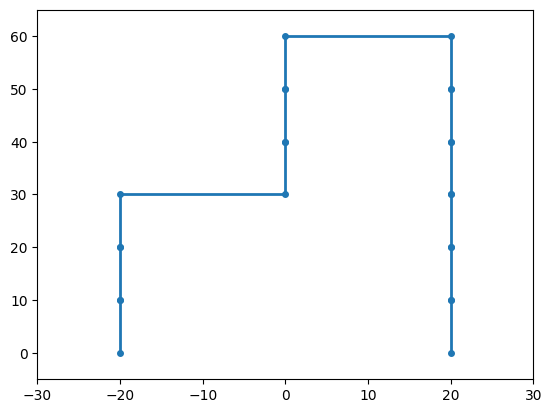

In [38]:
ff, xss, yss = stacked_trapezoids(-qxx, 
                                  qzz, 
                                  y1=list_param['left_coord'],
                                  y2=list_param['right_coord'], 
                                  height=list_param['height'], 
                                  langle=list_param['langle'], 
                                  rangle=list_param['langle'], 
                                  offset=list_param['ovl'], 
                                  profile=True)
plt.figure()
plt.plot(xss, yss, marker = 'o', linewidth=2, markersize=4)
plt.xlim(min(xss)-10, max(xss)+10)
plt.ylim(min(yss)-5, max(yss)+5)
plt.show()


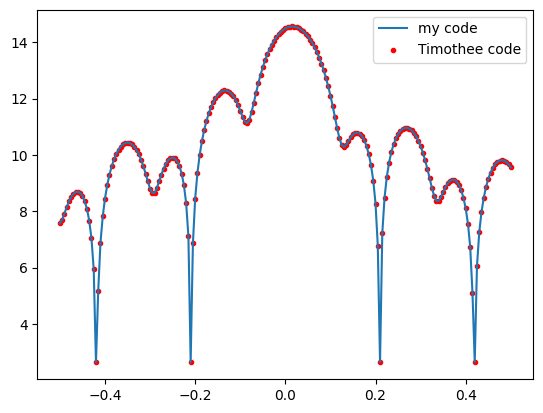

In [39]:
#read a file using numpy called testcastleshape.npy and print the content of the file

data = np.loadtxt('strong_castle.txt')

plt.plot(qzz, np.log(data), label='my code')
plt.scatter(qzz, np.log( np.abs(ff)**2 ) , label='Timothee code', marker='.', color='red')
plt.legend()